In [1]:
#!/bin/python3
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import copy

### statisitcs with uncertainties for charge changing with geometric corrections

In [2]:
def stat_errors_charge(filename_cc,geo_corr_file,target_thickness,adding):
    targettype = None
    factor = None
    n_t = None
    delta_n_t = None
    new_density = 1.851
    T_2198 = (new_density)*(2.1928)*(6.02214076)*(pow(10,23))/(12.011);
    T_1086 = (new_density)*(1.0793)*(6.02214076)*(pow(10,23))/(12.011);
    T_54 = (new_density)*(0.5451)*(6.02214076)*(pow(10,23))/(12.011);
    if (target_thickness == "thin"):
        targettype = "c_54"
        factor = (1./T_54)*(pow(10,27))
        n_t = T_54
        delta_n_t = 0.000648
    if (target_thickness == "medium"):
        targettype = "c_1086"
        n_t = T_1086
        delta_n_t = 0.002620
        factor = (1./T_1086)*(pow(10,27))
    if (target_thickness == "thick"):
        targettype = "c_2198"
        n_t = T_2198
        delta_n_t = 0.000322
        factor = (1./T_2198)*(pow(10,27))
        
    ##data frame for charge changing
    df_cc = pd.read_csv(filename_cc,sep='\t',names=["datatype","targettype","RunID","energy","incoming ions","survived_ions"])
    df_cc["d_carbon_survived"] = df_cc["survived_ions"]/df_cc["incoming ions"]
    ##data frame for geo correction
    df_geo = pd.read_csv(geo_corr_file,sep='\t',names=["datatype","targettype","RunID","energy","geo_corr_factor"])
    ### this step of doing the inverse is just needed for twim eff numbers!! DANGEROUS!
    df_geo["geo_corr_factor"] = 1./df_geo["geo_corr_factor"]

    cc_error_val = []
    cc_cs = []
    cc_cs_geo = []
    energy_vals = ["400","550","650","800"]
    for ene in energy_vals:
        #charge changing cross section
        dz = (float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived']))/(float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived']))
        cc = factor*(-math.log(dz))
        cc_cs.append(cc)
        #geo corr cross section
        d_geo = float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["geo_corr_factor"])/float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["geo_corr_factor"])
        cs_geo = factor*(-math.log(d_geo))
        if (adding =="true"):
            cc_cs_geo.append(cc+cs_geo) 
            print("hellooo")
        if (adding == "false"):
            cc_cs_geo.append(cc)
            print("not hello")

        ##now doing the stat. uncertainty calculations
        
        ### target thickness uncertainty
        target_error = pow(cc*delta_n_t,2)
        print("this is the target error",target_error)

        ### charge changing uncertainties
        r_cc_target = float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived'])
        r_cc_empty = float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived'])
        n_i_t_cc = float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['incoming ions'])
        n_i_e_cc = float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['incoming ions'])
        cc_error = (pow(10,54))*(1./(n_t*n_t))*((1-r_cc_target)/(r_cc_target*n_i_t_cc)+(1-r_cc_empty)/(r_cc_empty*n_i_e_cc))
        cc_error_val.append(math.sqrt(target_error+cc_error))

    return cc_cs_geo,cc_error_val

### here I use as geometric correction the twim efficiency factor
---

In [3]:
filename_cc = 'numbers/comb_gauss2d_border.txt'
filename_geo_corr = "total_eff_twim.txt"

cc_cs_geo_thin,cc_geo_error_thin = stat_errors_charge(filename_cc,filename_geo_corr,"thin",'true')
cc_cs_geo_medium,cc_geo_error_medium = stat_errors_charge(filename_cc,filename_geo_corr,"medium",'true')
cc_cs_geo_thick,cc_geo_error_thick = stat_errors_charge(filename_cc,filename_geo_corr,"thick",'true')


cc_cs_geo_thin_f,cc_geo_error_thin_f = stat_errors_charge(filename_cc,filename_geo_corr,"thin",'false')
cc_cs_geo_medium_f,cc_geo_error_medium_f = stat_errors_charge(filename_cc,filename_geo_corr,"medium",'false')
cc_cs_geo_thick_f,cc_geo_error_thick_f = stat_errors_charge(filename_cc,filename_geo_corr,"thick",'false')


hellooo
this is the target error 0.22818684283492688
hellooo
this is the target error 0.23504783717448632
hellooo
this is the target error 0.2364418163502543
hellooo
this is the target error 0.2397797436896805
hellooo
this is the target error 3.7208775694407707
hellooo
this is the target error 3.788395097452836
hellooo
this is the target error 3.846320483437709
hellooo
this is the target error 3.8884509510021514
hellooo
this is the target error 0.05602484968303486
hellooo
this is the target error 0.05656417162321622
hellooo
this is the target error 0.05905211368420743
hellooo
this is the target error 0.05988258222120142
not hello
this is the target error 0.22818684283492688
not hello
this is the target error 0.23504783717448632
not hello
this is the target error 0.2364418163502543
not hello
this is the target error 0.2397797436896805
not hello
this is the target error 3.7208775694407707
not hello
this is the target error 3.788395097452836
not hello
this is the target error 3.8463204834

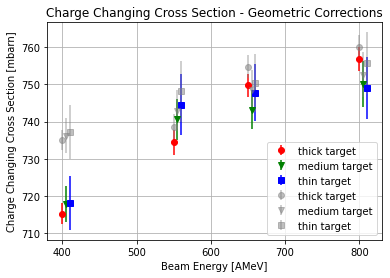

In [4]:
fig, ax = plt.subplots()
#fig.tight_layout()
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick,yerr=cc_geo_error_thick,label="thick target",color='red',marker="o",fmt="o")

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium,yerr=cc_geo_error_medium,label="medium target",color='green',marker="v",fmt="o")

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin,yerr=cc_geo_error_thin,label="thin target",color='blue',marker="s",fmt="o")

## whithout geo correction , in gray
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick_f,yerr=cc_geo_error_thick_f,label="thick target",color='gray',marker="o",fmt="o",alpha=0.5)

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium_f,yerr=cc_geo_error_medium_f,label="medium target",color='gray',marker="v",fmt="o",alpha=0.5)

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin_f,yerr=cc_geo_error_thin_f,label="thin target",color='gray',marker="s",fmt="o",alpha=0.5)

ax.legend()
ax.grid()
ax.set_xlabel("Beam Energy [AMeV]")
ax.set_ylabel("Charge Changing Cross Section [mbarn]")
ax.set_title("Charge Changing Cross Section - Geometric Corrections")
#ax.set_ylim(740,890)
plt.savefig("charge_changing_cross_sec_twim_eff_corr.png")

---

### here I use as geo correction the real geo cuts...
---

In [5]:
filename_cc = 'numbers/comb_gauss2d_border.txt'
filename_geo_corr = "orig_geo_corr_factor.txt"

cc_cs_geo_thin,cc_geo_error_thin = stat_errors_charge(filename_cc,filename_geo_corr,"thin",'true')
cc_cs_geo_medium,cc_geo_error_medium = stat_errors_charge(filename_cc,filename_geo_corr,"medium",'true')
cc_cs_geo_thick,cc_geo_error_thick = stat_errors_charge(filename_cc,filename_geo_corr,"thick",'true')


cc_cs_geo_thin_f,cc_geo_error_thin_f = stat_errors_charge(filename_cc,filename_geo_corr,"thin",'false')
cc_cs_geo_medium_f,cc_geo_error_medium_f = stat_errors_charge(filename_cc,filename_geo_corr,"medium",'false')
cc_cs_geo_thick_f,cc_geo_error_thick_f = stat_errors_charge(filename_cc,filename_geo_corr,"thick",'false')

hellooo
this is the target error 0.22818684283492688
hellooo
this is the target error 0.23504783717448632
hellooo
this is the target error 0.2364418163502543
hellooo
this is the target error 0.2397797436896805
hellooo
this is the target error 3.7208775694407707
hellooo
this is the target error 3.788395097452836
hellooo
this is the target error 3.846320483437709
hellooo
this is the target error 3.8884509510021514
hellooo
this is the target error 0.05602484968303486
hellooo
this is the target error 0.05656417162321622
hellooo
this is the target error 0.05905211368420743
hellooo
this is the target error 0.05988258222120142
not hello
this is the target error 0.22818684283492688
not hello
this is the target error 0.23504783717448632
not hello
this is the target error 0.2364418163502543
not hello
this is the target error 0.2397797436896805
not hello
this is the target error 3.7208775694407707
not hello
this is the target error 3.788395097452836
not hello
this is the target error 3.8463204834

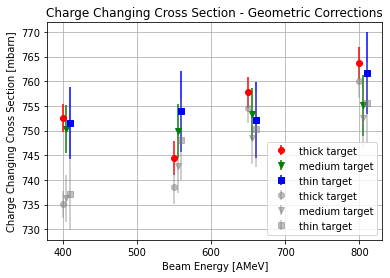

In [6]:
fig, ax = plt.subplots()
#fig.tight_layout()
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick,yerr=cc_geo_error_thick,label="thick target",color='red',marker="o",fmt="o")

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium,yerr=cc_geo_error_medium,label="medium target",color='green',marker="v",fmt="o")

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin,yerr=cc_geo_error_thin,label="thin target",color='blue',marker="s",fmt="o")

## whithout geo correction , in gray
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick_f,yerr=cc_geo_error_thick_f,label="thick target",color='gray',marker="o",fmt="o",alpha=0.5)

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium_f,yerr=cc_geo_error_medium_f,label="medium target",color='gray',marker="v",fmt="o",alpha=0.5)

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin_f,yerr=cc_geo_error_thin_f,label="thin target",color='gray',marker="s",fmt="o",alpha=0.5)

ax.legend()
ax.grid()
ax.set_xlabel("Beam Energy [AMeV]")
ax.set_ylabel("Charge Changing Cross Section [mbarn]")
ax.set_title("Charge Changing Cross Section - Geometric Corrections")
#ax.set_ylim(740,890)
plt.savefig("charge_changing_cross_sec_geo_cut_corr.png")